In [1]:
import numpy as np
import qiskit 
from qiskit import transpile, assemble,IBMQ
from qiskit.visualization import *
from qiskit.extensions import  UnitaryGate

#IBMQ.delete_accounts()
#IBMQ.save_account('2d7fb4a2d08cbb349872fe2229939996c6b01d6e420a129f9a63a5c8bb7c615394c422b44240dc09c275e506c6bad13d80776785cbfb36ef2e6ac297c9b85715')
#IBMQ.load_account()

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch.nn.parameter import Parameter

In [ ]:
is_colab = False
if is_colab:
    sys.exit(0)

In [2]:
#set parameter
interest_num = [3,6]
class_num = len(interest_num)
ori_img_size = 28
img_size = 4
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 8
inference_batch_size = 1
data_path = '/home/hzr/Software/quantum/qc_mnist/pytorch/data'

In [3]:
# Weiwen: modify the target classes starting from 0. Say, [3,6] -> [0,1]
def modify_target(target):
    for j in range(len(target)):
        for idx in range(len(interest_num)):
            if target[j] == interest_num[idx]:
                target[j] = idx
                break
    new_target = torch.zeros(target.shape[0],2)
    for i in range(target.shape[0]):        
        if target[i].item() == 0:            
            new_target[i] = torch.tensor([1,0]).clone()     
        else:
            new_target[i] = torch.tensor([0,1]).clone()
               
    return target,new_target

# Weiwen: select sub-set from MNIST
def select_num(dataset,interest_num):
    labels = dataset.targets #get labels
    labels = labels.numpy()
    idx = {}
    for num in interest_num:
        idx[num] = np.where(labels == num)
    fin_idx = idx[interest_num[0]]
    for i in range(1,len(interest_num)):           
        fin_idx = (np.concatenate((fin_idx[0],idx[interest_num[i]][0])),)
    
    fin_idx = fin_idx[0]    
    dataset.targets = labels[fin_idx]
    dataset.data = dataset.data[fin_idx]
    dataset.targets,_ = modify_target(dataset.targets)
    return dataset

In [4]:
################ Weiwen on 12-30-2020 ################
# Using torch to load MNIST data
######################################################

# convert data to torch.cdoubleTensor
transform = transforms.Compose([transforms.Resize((ori_img_size,ori_img_size)),
                                transforms.ToTensor()])
# Path to MNIST Dataset
train_data = datasets.MNIST(root=data_path, train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root=data_path, train=False,
                                  download=True, transform=transform)

train_data = select_num(train_data,interest_num)
test_data =  select_num(test_data,interest_num)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
    num_workers=num_workers, shuffle=True, drop_last=True)

/home/hzr/anaconda3/envs/qf/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:

################ Weiwen on 12-30-2020 ################
# Function: ToQuantumData from Listing 1
# Note: Coverting classical data to quantum data
######################################################
class ToQuantumData(object):
    def __call__(self, tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data = tensor.to(device)
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len, vec_len)
        input_matrix[0] = input_vec
        input_matrix = np.cdouble(input_matrix.transpose(0,1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = torch.tensor(np.dot(u, v),)
        output_data = output_matrix[:, 0].view(1, img_size,img_size)
        return output_data

################ Weiwen on 12-30-2020 ################
# Function: ToQuantumData from Listing 1
# Note: Coverting classical data to quantum matrix
######################################################
class ToQuantumMatrix(object):
    def __call__(self, tensor):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data = tensor.to(device)
        input_vec = data.view(-1)
        vec_len = input_vec.size()[0]
        input_matrix = torch.zeros(vec_len, vec_len)
        input_matrix[0] = input_vec
        input_matrix = np.cdouble(input_matrix.transpose(0,1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = torch.tensor(np.dot(u, v), dtype=torch.cdouble)
        return output_matrix   

################ Weiwen on 12-30-2020 ################
# T1: Downsample the image from 28*28 to 4*4
# T2: Convert classical data to quantum data which 
#     can be encoded to the quantum states (amplitude)
######################################################

# Process data by hand, we can also integrate ToQuantumData into transform
def data_pre_pro(img):
    # Print original figure
    img = img
    npimg = img.numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))    
    #plt.show()
    # Print resized figure
    image = np.asarray(npimg[0] * 255, np.uint8)    
    im = Image.fromarray(image,mode="L")
    im = im.resize((4,4),Image.BILINEAR)    
    #plt.imshow(im,cmap='gray',)
    #plt.show()
    # Converting classical data to quantum data
    trans_to_tensor = transforms.ToTensor()
    trans_to_vector = ToQuantumData()
    trans_to_matrix = ToQuantumMatrix()    
    #print("Classical Data: {}".format(trans_to_tensor(im).flatten()))
    #print("Quantum Data: {}".format(trans_to_vector(trans_to_tensor(im)).flatten()))
    return trans_to_matrix(trans_to_tensor(im)),trans_to_vector(trans_to_tensor(im))

# Use the first image from test loader as example
global g_quantum_matrix
for batch_idx, (data, target) in enumerate(test_loader):
    torch.set_printoptions(threshold=sys.maxsize)
    print("Batch Id: {}, Target: {}".format(batch_idx,target))
    g_quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data))
    break
  

Batch Id: 0, Target: tensor([1])


In [6]:
################ zhirui on 12-30-2020 ################
# this block is for buding variant circuit
######################################################
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

class VQuantumCircuit:    
    def __init__(self, n_qubits, backend, shots):
        # --- parameter definition ---
        #self._circuit = circuit
        self.n_qubits = n_qubits
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.ParameterVector('theta',n_qubits*7)
        self.theta = list(self.theta)
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    #define the circuit
    def vqc_10(self,circuit):

        #head ry part 
        for i in range(0,self.n_qubits):
            circuit.ry(self.theta[i], i)
        circuit.barrier()
        
        #cz part
        for i in range(self.n_qubits-1):
            circuit.cz(self.n_qubits-2-i,self.n_qubits-1-i)
        circuit.cz(0,self.n_qubits-1)
        circuit.barrier()

        #tail ry part
        for i in range(0,self.n_qubits):
            circuit.ry(self.theta[i+self.n_qubits], i)


    def vqc_5(self,circuit):
        for i in range(0,self.n_qubits):
            circuit.rx(self.theta[i],i)
        for i in range(0,self.n_qubits):
            circuit.rz(self.theta[self.n_qubits+i],i)
        
        circuit.barrier()
        cnt = 0
        for i in range(self.n_qubits-1,-1,-1):
            for j in range(self.n_qubits-1,-1,-1):
                if j == i:
                    continue
                else:
                    circuit.crz(self.theta[2*self.n_qubits + cnt],i,j)
                    cnt = cnt +1
            circuit.barrier()
        for i in range(0,self.n_qubits):
            circuit.rx(self.theta[5*self.n_qubits+i],i)
        for i in range(0,self.n_qubits):
            circuit.rz(self.theta[6*self.n_qubits+i],i)

    def build(self,circuit):
        self.vqc_5(circuit)
    
    def run(self,circuit, thetas):
    #define the whole circuit
        circuit.measure_all()

        t_qc = transpile(circuit,
                         self.backend)
        binds = {}
        for i in range(0,len(thetas)):#
            binds[self.theta[i]]= thetas[i]

        

        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [binds]
                        )
        job = self.backend.run(qobj)

        result = job.result().get_counts()
        # print("result:",result)

        #counts = np.array(list(result.values()))
        #states = np.array(list(result.keys())).astype(float)
        # Compute probabilities for each state
        output = np.zeros(self.n_qubits)
        for key in result.keys():
          result[key] =  result[key] / self.shots
          i=0
          for c in key:
              if c == '1':
                  output[i] =output[i]+ result[key]
              i = i+1
        return output


simulator = qiskit.Aer.get_backend('aer_simulator')
vqc = VQuantumCircuit(4, simulator, 100000)

# print("g_quantum_matrix:",g_quantum_matrix)
circuit = qiskit.QuantumCircuit(4)
circuit.append(UnitaryGate(g_quantum_matrix, label="Input"),range(0,4))
vqc.build(circuit)
print('probabilities :{}'.format(vqc.run(circuit,[np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9])))
circuit.draw()


result: {'1011': 127, '1001': 1731, '0010': 1748, '1101': 2293, '1000': 9842, '1100': 686, '0101': 11479, '0001': 22141, '1111': 114, '1010': 7929, '0000': 5544, '0011': 5428, '0111': 9994, '1110': 13525, '0110': 6449, '0100': 970}
probabilities :[0.36247 0.4551  0.45314 0.53307]


┌────────┐┌──────────────┐┌──────────────┐ ░                 »
   q_0: ┤0       ├┤ Rx(theta[0]) ├┤ Rz(theta[4]) ├─░─────────────────»
        │        │├──────────────┤├──────────────┤ ░                 »
   q_1: ┤1       ├┤ Rx(theta[1]) ├┤ Rz(theta[5]) ├─░─────────────────»
        │  Input │├──────────────┤├──────────────┤ ░ ┌──────────────┐»
   q_2: ┤2       ├┤ Rx(theta[2]) ├┤ Rz(theta[6]) ├─░─┤ Rz(theta[8]) ├»
        │        │├──────────────┤├──────────────┤ ░ └──────┬───────┘»
   q_3: ┤3       ├┤ Rx(theta[3]) ├┤ Rz(theta[7]) ├─░────────■────────»
        └────────┘└──────────────┘└──────────────┘ ░                 »
meas: 4/═════════════════════════════════════════════════════════════»
                                                                     »
«                        ┌───────────────┐ ░                                   »
«   q_0: ────────────────┤ Rz(theta[10]) ├─░───────────────────────────────────»
«        ┌──────────────┐└───────┬───────┘ ░                  ┌───────────────┐»
«   q_1: ┤ Rz(theta[9]) ├────────┼─────────░──────────────────┤ Rz(theta[12]) ├»
«        └──────┬───────┘        │         ░                  └───────┬───────┘»
«   q_2: ───────┼────────────────┼─────────░─────────■────────────────■────────»
«               │                │         ░ ┌───────┴───────┐                 »
«   q_3: ───────■────────────────■─────────░─┤ Rz(theta[11]) ├─────────────────»
«                                          ░ └───────────────┘                 »
«meas: 4/══════════════════════════════════════════════════════════════════════»
«                                                                              »
«        ┌───────────────┐ ░                                   »
«   q_0: ┤ Rz(theta[13]) ├─░───────────────────────────────────»
«        └───────┬───────┘ ░                                   »
«   q_1: ────────┼─────────░─────────■────────────────■────────»
«                │         ░         │        ┌───────┴───────┐»
«   q_2: ────────■─────────░─────────┼────────┤ Rz(theta[15]) ├»
«                          ░ ┌───────┴───────┐└───────────────┘»
«   q_3: ──────────────────░─┤ Rz(theta[14]) ├─────────────────»
«                          ░ └───────────────┘                 »
«meas: 4/══════════════════════════════════════════════════════»
«                                                              »
«        ┌───────────────┐ ░                                   »
«   q_0: ┤ Rz(theta[16]) ├─░─────────■────────────────■────────»
«        └───────┬───────┘ ░         │                │        »
«   q_1: ────────■─────────░─────────┼────────────────┼────────»
«                          ░         │        ┌───────┴───────┐»
«   q_2: ──────────────────░─────────┼────────┤ Rz(theta[18]) ├»
«                          ░ ┌───────┴───────┐└───────────────┘»
«   q_3: ──────────────────░─┤ Rz(theta[17]) ├─────────────────»
«                          ░ └───────────────┘                 »
«meas: 4/══════════════════════════════════════════════════════»
«                                                              »
«                          ░ ┌───────────────┐┌───────────────┐ ░ ┌─┐         
«   q_0: ────────■─────────░─┤ Rx(theta[20]) ├┤ Rz(theta[24]) ├─░─┤M├─────────
«        ┌───────┴───────┐ ░ ├───────────────┤├───────────────┤ ░ └╥┘┌─┐      
«   q_1: ┤ Rz(theta[19]) ├─░─┤ Rx(theta[21]) ├┤ Rz(theta[25]) ├─░──╫─┤M├──────
«        └───────────────┘ ░ ├───────────────┤├───────────────┤ ░  ║ └╥┘┌─┐   
«   q_2: ──────────────────░─┤ Rx(theta[22]) ├┤ Rz(theta[26]) ├─░──╫──╫─┤M├───
«                          ░ ├───────────────┤├───────────────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ──────────────────░─┤ Rx(theta[23]) ├┤ Rz(theta[27]) ├─░──╫──╫──╫─┤M├
«                          ░ └───────────────┘└───────────────┘ ░  ║  ║  ║ └╥┘
«meas: 4/══════════════════════════════════════════════════════════╩══╩══╩══╩═
«                                                                  0  1  2  3

In [7]:
################ zhirui on 12-30-2020 ################
# this block is for buding the matrix of variant circuit
######################################################
import math
class VClassicCircuitMatrix:
    def __init__(self, n_qubits):
        # --- parameter definition ---
        self._n_qubits = n_qubits
        #state = state
        #constant matrix
        self.mat_cz = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])
        self.mat_identity = torch.tensor([[1,0],[0,1]])
        self.mat_swap = torch.tensor([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

    def set_value(self,mm,col,row,val):
        index = (torch.LongTensor([col]),torch.LongTensor([row]))#生成索引
        #value = torch.Tensor(val) #生成要填充的值
        mm = mm.index_put(index ,val)
        return mm

    def get_ry_matrix(self,theta):
        mm = torch.zeros(2,2,dtype=torch.cdouble)
        mm = self.set_value(mm,0,0,torch.cos(theta/2))
        mm = self.set_value(mm,0,1,-torch.sin(theta/2))
        mm = self.set_value(mm,1,0,torch.sin(theta/2))
        mm = self.set_value(mm,1,1,torch.cos(theta/2))
        return mm

    def get_rx_matrix(self,theta):
        mm = torch.zeros(2,2,dtype=torch.cdouble)
        mm = self.set_value(mm,0,0,torch.cos(theta/2))
        mm = self.set_value(mm,0,1,-1j*torch.sin(theta/2))
        mm = self.set_value(mm,1,0,-1j*torch.sin(theta/2))
        mm = self.set_value(mm,1,1,torch.cos(theta/2))
        return mm

    def get_rz_matrix(self,theta):
        mm = torch.zeros(2,2,dtype=torch.cdouble)
        mm = self.set_value(mm,0,0,torch.exp(-1j*theta/2))
        mm = self.set_value(mm,1,1,torch.exp(1j*theta/2))
        return mm  

    def get_ctrl_rx_matrix(self,theta):
        mm = torch.zeros(4,4,dtype=torch.cdouble)
        mm = self.set_value(mm,0,0,torch.tensor(1,dtype=torch.cdouble))
        mm = self.set_value(mm,1,1,torch.tensor(1,dtype=torch.cdouble))
        mm = self.set_value(mm,2,2,torch.cos(theta/2))
        mm = self.set_value(mm,2,3,-1j*torch.sin(theta/2))
        mm = self.set_value(mm,3,2,-1j*torch.sin(theta/2))
        mm = self.set_value(mm,3,3,torch.cos(theta/2))
        return mm

    def get_ctrl_ry_matrix(self,theta):
        mm = torch.zeros(4,4,dtype=torch.cdouble)
        mm = self.set_value(mm,0,0,torch.tensor(1,dtype=torch.cdouble))
        mm = self.set_value(mm,1,1,torch.tensor(1,dtype=torch.cdouble))
        mm = self.set_value(mm,2,2,torch.cos(theta/2))
        mm = self.set_value(mm,2,3,-torch.sin(theta/2))
        mm = self.set_value(mm,3,2,torch.sin(theta/2))
        mm = self.set_value(mm,3,3,torch.cos(theta/2))
        return mm

    def get_ctrl_rz_matrix(self,theta):
        mm = torch.zeros(4,4,dtype=torch.cdouble)
        mm = self.set_value(mm,0,0,torch.tensor(1,dtype=torch.cdouble))
        mm = self.set_value(mm,1,1,torch.tensor(1,dtype=torch.cdouble))
        mm = self.set_value(mm,2,2,torch.exp(-1j*theta/2))
        mm = self.set_value(mm,3,3,torch.exp(1j*theta/2))
        return mm

    #swap (index) and (index-1)        
    def qf_swap_dec(self,state,index):
        #generate the matrix
        temp_mat = torch.ones(1,dtype=torch.cdouble)
        for i in range(0,index-1):
            temp_mat = torch.kron(self.mat_identity,temp_mat)
        temp_mat =torch.kron(self.mat_swap,temp_mat)
        for i in range(0,self._n_qubits-1-index):
            temp_mat = torch.kron(self.mat_identity,temp_mat)
        #change state
        state = torch.mm(temp_mat,state) 
        return state 


    def qf_ry(self,state,theta,index):
        temp_mat = torch.ones(1,dtype=torch.cdouble)
        if isinstance(index,int): 
            for i in range(0,self._n_qubits):
                if i == index:
                    mm = self.get_ry_matrix(theta)
                    temp_mat = torch.kron(mm,temp_mat) 
                else:
                    temp_mat = torch.kron(self.mat_identity,temp_mat) 
        else:
            for i in range(0,self._n_qubits):
                if i in index:
                    select_theta = torch.index_select(theta,0,torch.tensor([i]))
                    select_mm = self.get_ry_matrix(select_theta)
                    temp_mat = torch.kron(select_mm,temp_mat)

                else:
                    temp_mat = torch.kron(self.mat_identity,temp_mat) 
        state = torch.mm(temp_mat,state)   
        return state

    def qf_rx(self,state,theta,index):
        temp_mat = torch.ones(1,dtype=torch.cdouble)
        if isinstance(index,int): 
            for i in range(0,self._n_qubits):
                if i == index:
                    mm = self.get_rx_matrix(theta)
                    temp_mat = torch.kron(mm,temp_mat) 
                else:
                    temp_mat = torch.kron(self.mat_identity,temp_mat) 
        else:
            for i in range(0,self._n_qubits):
                if i in index:
                    select_theta = torch.index_select(theta,0,torch.tensor([i]))
                    select_mm = self.get_rx_matrix(select_theta)
                    temp_mat = torch.kron(select_mm,temp_mat)

                else:
                    temp_mat = torch.kron(self.mat_identity,temp_mat) 
        state = torch.mm(temp_mat,state)   
        return state

    def qf_rz(self,state,theta,index):
        temp_mat = torch.ones(1,dtype=torch.cdouble)
        if isinstance(index,int): 
            for i in range(0,self._n_qubits):
                if i == index:
                    mm = self.get_rz_matrix(theta)
                    temp_mat = torch.kron(mm,temp_mat) 
                else:
                    temp_mat = torch.kron(self.mat_identity,temp_mat) 
        else:
            for i in range(0,self._n_qubits):
                if i in index:
                    select_theta = torch.index_select(theta,0,torch.tensor([i]))
                    select_mm = self.get_rz_matrix(select_theta)
                    temp_mat = torch.kron(select_mm,temp_mat)

                else:
                    temp_mat = torch.kron(self.mat_identity,temp_mat) 
        state = torch.mm(temp_mat,state)   
        return state

            
    def qf_cz(self,state,index1,index2):

        #generate the matrix
        
        #swap the bottom one next to the up one
        for i in range(index2,index1+1,-1):
            state = self.qf_swap_dec(state,i)
        
        #generate cz matrix
        temp_mat = torch.ones(1,dtype=torch.cdouble)
        for i in range(0,index1):
            temp_mat = torch.kron(self.mat_identity,temp_mat)

        temp_mat =torch.kron(self.mat_cz,temp_mat)

        for i in range(0,self._n_qubits-2-index1):
            temp_mat = torch.kron(self.mat_identity,temp_mat)

        #change state
        state = torch.mm(temp_mat,state)   

        #swap back
        for i in range(index1+2,index2+1):
            state = self.qf_swap_dec(state,i)

        return state

    def qf_c_r(self,state,theta,name,index_c,index_r):
        
        if name == 'x':
            self.mat_r = self.get_ctrl_rx_matrix(theta)
        elif name == 'y':
            self.mat_r = self.get_ctrl_ry_matrix(theta)
        elif name == 'z':
            self.mat_r = self.get_ctrl_rz_matrix(theta)

        if index_c > index_r:
            #swap the bottom one next to the up one
            for i in range(index_r+1,index_c+1):
                state = self.qf_swap_dec(state,i)
        
            #generate cz matrix
            temp_mat = torch.ones(1,dtype=torch.cdouble)

            for i in range(0,index_c-1):
                temp_mat = torch.kron(self.mat_identity,temp_mat)
        
            
            temp_mat =torch.kron(self.mat_r,temp_mat)

            for i in range(0,self._n_qubits-1-index_c):
                temp_mat = torch.kron(self.mat_identity,temp_mat)

            #change state
            state = torch.mm(temp_mat,state)   

            #swap back
            for i in range(index_c,index_r,-1):
                state = self.qf_swap_dec(state,i)  
        else:
            #swap the bottom one next to the up one
            for i in range(index_r,index_c+1,-1):
                state = self.qf_swap_dec(state,i)
        
            #generate cz matrix
            temp_mat = torch.ones(1,dtype=torch.cdouble)
            for i in range(0,index_c):
                temp_mat = torch.kron(self.mat_identity,temp_mat)

            temp_mat =torch.kron(self.mat_r,temp_mat)

            for i in range(0,self._n_qubits-2-index_c):
                temp_mat = torch.kron(self.mat_identity,temp_mat)

            #change state
            state = torch.mm(temp_mat,state)   

            #swap back
            for i in range(index_c+2,index_r+1):
                state = self.qf_swap_dec(state,i)                           
        return state



    #get the matrix transforming 16 output to 4 output.     
    def qf_sum(self):
        sum_mat = []
        flag = "0"+str(self._n_qubits)+"b"
        for i in range(0,int(math.pow(2,self._n_qubits))):
            bit_str = format(i,flag)
            row = []
            for c in bit_str:
                row.append(float(c))
            sum_mat.append(row)
        return sum_mat


    #the code is similar to the VQuantumCircuit::vqc_10
    def vqc_10(self,state,thetas):
        
        #head ry part 
        state = self.qf_ry(state,thetas[0:self._n_qubits],range(0,self._n_qubits))
        for i in range(self._n_qubits-1):
            state = self.qf_cz(state,self._n_qubits-2-i,self._n_qubits-1-i)
        state = self.qf_cz(state,0,self._n_qubits-1)

        state = self.qf_ry(state,thetas[self._n_qubits:2*self._n_qubits],range(0,self._n_qubits))

        return state

    #the code is similar to the VQuantumCircuit::vqc_5
    def vqc_5(self,state,thetas):
        
        state = self.qf_rx(state,thetas[0:self._n_qubits],range(0,self._n_qubits))
        state = self.qf_rz(state,thetas[self._n_qubits:2*self._n_qubits],range(0,self._n_qubits))
        cnt = 0
        for i in range(self._n_qubits-1,-1,-1):
            for j in range(self._n_qubits-1,-1,-1):
                if j == i:
                    continue
                else:
                    state = self.qf_c_r(state,thetas[2*self._n_qubits + cnt],'z',i,j)
                    cnt = cnt +1
        state = self.qf_rx(state,thetas[5*self._n_qubits:6*self._n_qubits],range(0,self._n_qubits))
        state = self.qf_rz(state,thetas[6*self._n_qubits:7*self._n_qubits],range(0,self._n_qubits))
        return state 

    def measurement(self,state):
        sum_mat = torch.tensor(self.qf_sum(),dtype=torch.double) 
        sum_mat = sum_mat.t()
        state = state.abs()*state.abs()
        # print("state:",state)


        state = torch.mm(sum_mat,state)
        return state

        
    def run(self,state, thetas):
        state =self.vqc_5(state,thetas)
        state = self.measurement(state)
        return state 


vcm = VClassicCircuitMatrix(4)
test_state = torch.zeros(int(math.pow(2,4)),1,dtype=torch.cdouble)
test_state =test_state.scatter(0,torch.tensor([[0]]),1.0)
# print('g_quantum_matrix :',g_quantum_matrix)
test_state = torch.mm(g_quantum_matrix,test_state)

test_theta = torch.tensor( [np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9],dtype= torch.cdouble,requires_grad= True)
result = vcm.run(test_state,test_theta)
print('matrix probabilities :',result.t())

circuit = qiskit.QuantumCircuit(4)
circuit.append(UnitaryGate(g_quantum_matrix, label="Input"),range(0,4))
vqc.build(circuit)
print('simulator probabilities :{}'.format(vqc.run(circuit,[np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9])))

matrix probabilities : tensor([[0.4638, 0.4499, 0.5566, 0.5334]], dtype=torch.float64,
       grad_fn=<TBackward>)
result: {'1011': 103, '0010': 1811, '1001': 1737, '1101': 2343, '1100': 625, '0101': 11644, '1111': 82, '1010': 7873, '0000': 5585, '0011': 5560, '0111': 10044, '1000': 9624, '0001': 22148, '0100': 1008, '0110': 6437, '1110': 13376}
simulator probabilities :[0.35763 0.45559 0.45286 0.53661]


In [8]:
################ hzr on 12-30-2020 ###################
#This block is for building the main net,including init and forward.
######################################################

class Net(nn.Module):
    def __init__(self,num_qubit,init_para):
        super(Net, self).__init__()

        #init parameter
        self.num_qubit = num_qubit
        self.theta= Parameter(torch.tensor(init_para,  dtype=torch.cdouble,requires_grad=True))
        self.theta2= Parameter(torch.tensor(init_para,  dtype=torch.cdouble,requires_grad=True))
        self.theta3= Parameter(torch.tensor(init_para,  dtype=torch.cdouble,requires_grad=True))

        #init  VClassicCircuitMatrix
        self.vcm = VClassicCircuitMatrix(num_qubit)


        #init circuit
        self.simulator = qiskit.Aer.get_backend('aer_simulator')
        self.shots = 10000
        self.vqc = VQuantumCircuit(num_qubit, self.simulator,self.shots )



        #init FC
        self.fc = nn.Linear(num_qubit, 2)

    def forward(self, x ,training=True,classic = True):
        
        if classic:
            if not training: #test on classic 
                mstate = torch.zeros(int(math.pow(2,self.num_qubit )),1, dtype=torch.cdouble)
                mstate = mstate.scatter(0,torch.tensor([[0]]),1.0)

                # u matrix
                mstate = torch.mm(x,mstate)
                # variance circuit matrix
                # mstate = vcm.run(mstate,self.theta)
                # mstate = vcm.run(mstate,self.theta2)
                mstate = vcm.run(mstate,self.theta3)
                mstate = torch.take(mstate, torch.tensor(range(0,class_num)))
                # FC 
                # mstate = self.fc(mstate.t().float())
                #softmax
                # mstate = mstate*-1
                mstate = mstate.view(1,-1)
                # mstate = F.log_softmax(mstate,dim=-1)
                return mstate

            else: #train on classic
                mstate = torch.zeros(int(math.pow(2,self.num_qubit )),1, dtype=torch.cdouble)
                mstate = mstate.scatter(0,torch.tensor([[0]]),1.0)
                # u matrix
                mstate = torch.mm(x,mstate)
                # variance circuit matrix
                # mstate = vcm.vqc_10(mstate,self.theta)
                # mstate = vcm.vqc_10(mstate,self.theta2)
                mstate = vcm.vqc_10(mstate,self.theta3)
                mstate = vcm.measurement(mstate)
                mstate = torch.take(mstate, torch.tensor(range(0,class_num)))
                # mstate = mstate*-1

                # FC 
                # mstate = self.fc(mstate.t().float())
                #softmax
                mstate = mstate.view(1,-1)
                return mstate
                
        else:#only test on qubit
            #init circuit
            mcircuit = qiskit.QuantumCircuit(self.num_qubit)
            mcircuit.append(UnitaryGate(x, label="Input"),range(0,4))

            self.vqc.build(mcircuit)
            np_theta3 =  self.theta3.detach().numpy()
            mstate = self.vqc.run(mcircuit,np_theta3)
            mstate = torch.tensor(mstate)
            mstate = torch.take(mstate, torch.tensor(range(0,class_num)))
            # FC 
            # mstate = self.fc(mstate.float())
            #softmax
            mstate = mstate.view(1,-1)
            return  mstate



In [9]:
################ hzr on 12-30-2020 ###################
#This block is for training on classical computer
######################################################
model = Net(4,[np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9,np.pi,np.pi/4,np.pi/10,np.pi/2,
                                                  np.pi/3,np.pi/4,np.pi/3,np.pi/9])
optimizer = optim.Adam(model.parameters(), lr=0.01)
for itor in model.parameters():
    print(itor)
loss_func = nn.NLLLoss() #

epochs = 4
loss_list = []
#active batch_normal and drop out.
model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Data prepare
        output =[]
        for data_item in data: 
            quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data_item))
            # Forward pass
            output_item = model(quantum_matrix)
            output_item = F.log_softmax(output_item,dim=-1)
            output.append(output_item)
            

        output = torch.cat(output,dim=0)
        
        target = target.view(-1)
        #print("output 01:",output)
        #print('target 01:',target)
        # Calculating loss
        # print("output:",output)
        # print("target:",target)
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # print(model.theta.grad)
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


Parameter containing:
tensor([1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j, 0.7854+0.j, 0.3142+0.j,
        1.5708+0.j, 1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j, 0.7854+0.j,
        0.3142+0.j, 1.5708+0.j, 1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j,
        0.7854+0.j, 0.3142+0.j, 1.5708+0.j, 1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j],
       dtype=torch.complex128, requires_grad=True)
Parameter containing:
tensor([1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j, 0.7854+0.j, 0.3142+0.j,
        1.5708+0.j, 1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j, 0.7854+0.j,
        0.3142+0.j, 1.5708+0.j, 1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j,
        0.7854+0.j, 0.3142+0.j, 1.5708+0.j, 1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j],
       dtype=torch.complex128, requires_grad=True)
Parameter containing:
tensor([1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j, 0.7854+0.j, 0.3142+0.j,
  

Text(0, 0.5, 'Neg Log Likelihood Loss')

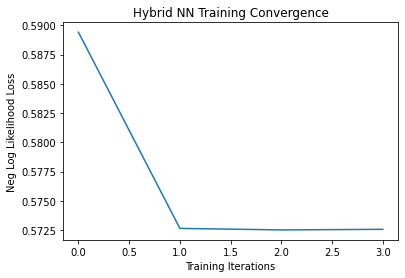

In [10]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')


In [14]:
################ hzr on 12-30-2020 ###################
#This block is for testing on classical computer
######################################################
model.eval()
# 下面的代码不会更新梯度
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        
        quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data))
        output = model(quantum_matrix,False,False)
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )


result: {'0010': 211, '1001': 105, '1110': 486, '1011': 500, '0001': 557, '1101': 475, '1100': 253, '0101': 99, '1000': 977, '0000': 544, '0011': 409, '0111': 3218, '1010': 80, '1111': 777, '0110': 212, '0100': 1097}
result: {'1001': 68, '0010': 212, '1010': 50, '1111': 637, '0001': 235, '1110': 657, '1101': 411, '0011': 446, '0000': 552, '0111': 3108, '1011': 617, '0110': 352, '0100': 1485, '0101': 113, '1100': 591, '1000': 466}
result: {'1011': 6, '1001': 18, '0010': 63, '1101': 152, '0001': 679, '0101': 114, '1100': 1029, '0110': 117, '0100': 561, '1000': 1952, '1110': 694, '0011': 900, '0111': 1310, '0000': 1683, '1010': 366, '1111': 356}
result: {'0010': 25, '1101': 29, '1001': 5, '1011': 18, '0001': 536, '0100': 221, '0110': 69, '1000': 2488, '1110': 713, '0011': 964, '0000': 777, '0111': 1341, '1111': 407, '1010': 490, '0101': 437, '1100': 1480}
result: {'1001': 2, '1011': 213, '0010': 383, '1010': 167, '1111': 497, '0001': 836, '0110': 111, '0100': 687, '0000': 1751, '0011': 17

result: {'1001': 41, '1101': 32, '1011': 109, '0010': 61, '0001': 297, '0100': 653, '0110': 364, '0000': 446, '0011': 323, '0111': 4135, '1111': 158, '1010': 271, '1100': 943, '0101': 224, '1000': 1162, '1110': 781}
model.theta: Parameter containing:
tensor([1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j, 0.7854+0.j, 0.3142+0.j,
        1.5708+0.j, 1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j, 0.7854+0.j,
        0.3142+0.j, 1.5708+0.j, 1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j,
        0.7854+0.j, 0.3142+0.j, 1.5708+0.j, 1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j],
       dtype=torch.complex128, requires_grad=True)
result: {'0010': 4, '1011': 6, '1001': 32, '0101': 144, '1100': 867, '1101': 16, '1000': 2902, '0001': 651, '0100': 670, '0110': 243, '0011': 895, '0111': 684, '0000': 1744, '1111': 153, '1010': 561, '1110': 428}
model.theta: Parameter containing:
tensor([1.0472+0.j, 0.7854+0.j, 1.0472+0.j, 0.3491+0.j, 3.1416+0.j, 0.7854+0.j, 0

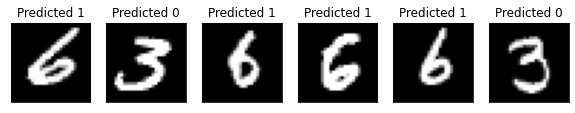

In [13]:
################ hzr on 12-30-2020 ###################
#This block is for testing on quantum computer.
######################################################
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        quantum_matrix,qantum_data = data_pre_pro(torchvision.utils.make_grid(data))
        output = model(quantum_matrix,False,False)        
        pred = output.argmax(dim=1, keepdim=True) 
        print ("model.theta:",model.theta)

        # output = model(quantum_matrix,False,True)        
        # pred = output.argmax(dim=1, keepdim=True) 


        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1
